In [2]:
# Cargar la base de datos
df = pd.read_stata("enoe_23t4.dta")

# Mostrar las primeras filas
df.head()

,ent,sex,n_hij,ur,fac_tri,fac_men,clase2
0,Nuevo LeÃ³n,Hombre,NaN,Urbano,565.0,1847.0,PoblaciÃ³n ocupada
1,Nuevo LeÃ³n,Hombre,NaN,Urbano,565.0,1847.0,PoblaciÃ³n ocupada
2,Nuevo LeÃ³n,Mujer,Tres hijos,Urbano,565.0,1847.0,No disponibles
3,Nuevo LeÃ³n,Mujer,Dos hijos,Urbano,565.0,1847.0,No disponibles
4,Nuevo LeÃ³n,Mujer,NaN,Urbano,565.0,1847.0,No aplica


In [3]:
# Paso 1: Obtener una muestra aleatoria representativa de n=1000
# Verificar si hay valores nulos en la columna de ponderación
print("Valores nulos en 'fac_tri':", df['fac_tri'].isnull().sum())

# Eliminar filas con valores nulos en 'fac_tri' antes de hacer el muestreo ponderado
df = df.dropna(subset=['fac_tri'])

# Paso 1: Obtener una muestra aleatoria representativa de n=1000 con ponderación
df_sample = df.sample(n=1000, weights=df['fac_tri'], random_state=42)

# Mostrar las primeras filas de la muestra
print(df_sample.head())


Valores nulos en 'fac_tri': 0
                                    ent     sex  \
196641                Ciudad de MÃ©xico   Mujer   
405884  Veracruz de Ignacio de la Llave  Hombre   
342226                          Sinaloa   Mujer   
300958                      Nuevo LeÃ³n   Mujer   
73123                   Baja California   Mujer   

                                            n_hij      ur  fac_tri  fac_men  \
196641                                  Dos hijos  Urbano    732.0   2283.0   
405884                                        NaN   Rural   1207.0   3472.0   
342226  Es menor o es hombre o es mujer sin hijos   Rural    428.0   1399.0   
300958                               Cuatro Hijos   Rural    491.0   1573.0   
73123   Es menor o es hombre o es mujer sin hijos  Urbano    237.0    822.0   

                    clase2  
196641  PoblaciÃ³n ocupada  
405884  PoblaciÃ³n ocupada  
342226      No disponibles  
300958      No disponibles  
73123       No disponibles  


In [4]:
#Paso 2: Tabular la variable de sexo donde hombres=1 y mujeres=2 (antes y después de la muestra n=1000 / eliminando advertencia
    # Verificar los valores únicos en la columna "sex" para confirmar cómo están codificados
print("Valores únicos en 'sex':", df['sex'].unique())

# Si "sex" es categórica, usamos .cat.rename_categories() en lugar de .replace()
if isinstance(df['sex'].dtype, pd.CategoricalDtype):
    df['sex'] = df['sex'].cat.rename_categories({'Hombre': 1, 'Mujer': 2})
    df_sample['sex'] = df_sample['sex'].cat.rename_categories({'Hombre': 1, 'Mujer': 2})
else:
    df['sex'] = df['sex'].replace({'Hombre': 1, 'Mujer': 2})
    df_sample['sex'] = df_sample['sex'].replace({'Hombre': 1, 'Mujer': 2})

# Función para tabular la variable "sexo"
def tabular_sexo(df, nombre):
    tab = df['sex'].value_counts(normalize=True)  # Calcula proporciones
    return pd.DataFrame({'Sexo': tab.index, 'Proporción': tab.values, 'Muestra': nombre})

# Tabulación en la población total antes del muestreo
original_tab = tabular_sexo(df, "Población total")

# Tabulación en la muestra de 1000 después del muestreo
muestra_tab = tabular_sexo(df_sample, "Muestra de 1000")

# Concatenar los resultados para comparación
tabla_comparativa = pd.concat([original_tab, muestra_tab], ignore_index=True)

# Mostrar la tabla comparativa
print(tabla_comparativa)


Valores únicos en 'sex': ['Hombre', 'Mujer', NaN]
Categories (2, object): ['Hombre' < 'Mujer']
  Sexo  Proporción          Muestra
0    2    0.521903  Población total
1    1    0.478097  Población total
2    2    0.519000  Muestra de 1000
3    1    0.481000  Muestra de 1000


In [5]:
#Paso 2: Tabular la variable de sexo donde hombres=1 y mujeres=2 (antes y después de la muestra n=1000 / Representación en una Tabla
import pandas as pd

# Crear una tabla con formato mejorado usando Pandas Styler
styled_table = tabla_comparativa.style.set_properties(**{
    'background-color': 'white',
    'color': 'black',
    'border': '1px solid black'
}).set_caption("Distribución de Hombres y Mujeres en la Población y la Muestra")

# Mostrar la tabla con estilo
styled_table


,Sexo,Proporción,Muestra
0,2,0.521903,Población total
1,1,0.478097,Población total
2,2,0.519000,Muestra de 1000
3,1,0.481000,Muestra de 1000


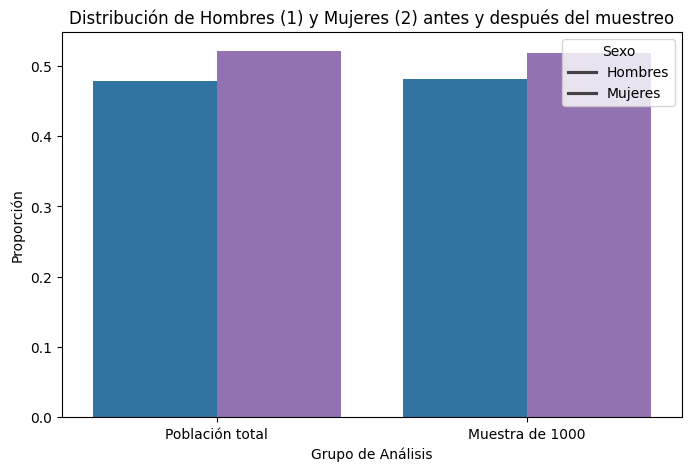

In [6]:
#paso 2: Tabular la variable de sexo donde hombres=1 y mujeres=2 (antes y después de la muestra n=1000) / Representación en un Gráfico de Barras
import matplotlib.pyplot as plt
import seaborn as sns

# Definir colores personalizados: Azul Rey (#1f77b4) para hombres, Morado (#9467bd) para mujeres
custom_palette = {1: "#1f77b4", 2: "#9467bd"}  # Hombres: Azul Rey, Mujeres: Morado

# Crear el gráfico de barras con colores
plt.figure(figsize=(8,5))
sns.barplot(data=tabla_comparativa, x="Muestra", y="Proporción", hue="Sexo", palette=custom_palette)

# Agregar títulos y etiquetas
plt.title("Distribución de Hombres (1) y Mujeres (2) antes y después del muestreo")
plt.ylabel("Proporción")
plt.xlabel("Grupo de Análisis")
plt.legend(title="Sexo", labels=["Hombres", "Mujeres"])

# Mostrar gráfico
plt.show()



In [7]:
#Paso 3: calcula los intervalos de confianza (IC) al 95% para las proporciones de hombres y mujeres en la población total y la muestra de 1000.
    
import statsmodels.stats.proportion as smp
import pandas as pd

# Función para calcular intervalos de confianza de proporciones
def calcular_ic(tab, n):
    resultados = []
    for _, row in tab.iterrows():
        sexo = row['Sexo']
        prop = row['Proporción']
        count = int(prop * n)  # Convertir la proporción a número de casos
        ic_low, ic_high = smp.proportion_confint(count, nobs=n, alpha=0.05, method='wilson')

        resultados.append({'Sexo': sexo, 'IC Bajo': ic_low, 'IC Alto': ic_high, 'Muestra': row['Muestra']})
    
    return pd.DataFrame(resultados)

# Calcular IC para la población total
ic_original = calcular_ic(original_tab, len(df))

# Calcular IC para la muestra de 1000
ic_muestra = calcular_ic(muestra_tab, 1000)

# Concatenar resultados
ic_resultados = pd.concat([ic_original, ic_muestra], ignore_index=True)

# Mostrar la tabla con los intervalos de confianza
print(ic_resultados)


   Sexo   IC Bajo   IC Alto          Muestra
0     2  0.520391  0.523413  Población total
1     1  0.476585  0.479606  Población total
2     2  0.488019  0.549835  Muestra de 1000
3     1  0.450165  0.511981  Muestra de 1000


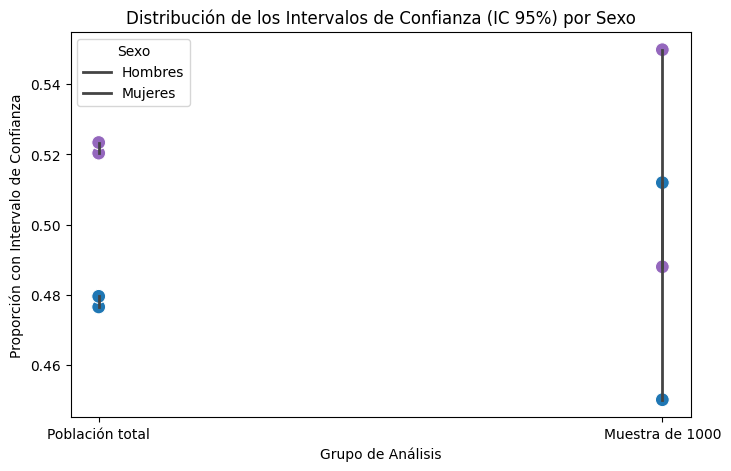

In [8]:
#Paso 3: calcula los intervalos de confianza (IC) al 95% para las proporciones de hombres y mujeres en la población total y la muestra de 1000.  / Representación en un Gráfico de Puntos con Líneas de IC

plt.figure(figsize=(8,5))

# Graficar los intervalos de confianza
for i, row in ic_resultados.iterrows():
    plt.plot([row["Muestra"], row["Muestra"]], [row["IC Bajo"], row["IC Alto"]],
             color="#444444", linewidth=2)  # Línea vertical del intervalo

# Graficar los puntos de la proporción
sns.scatterplot(data=ic_resultados, x="Muestra", y="IC Bajo", hue="Sexo", s=100, palette={1: "#1f77b4", 2: "#9467bd"})
sns.scatterplot(data=ic_resultados, x="Muestra", y="IC Alto", hue="Sexo", s=100, palette={1: "#1f77b4", 2: "#9467bd"})

# Etiquetas
plt.title("Distribución de los Intervalos de Confianza (IC 95%) por Sexo")
plt.ylabel("Proporción con Intervalo de Confianza")
plt.xlabel("Grupo de Análisis")
plt.legend(title="Sexo", labels=["Hombres", "Mujeres"])

plt.show()



In [9]:
# Error----- Paso 4:  Obtener la Población ocupada en México por género: Para el pais y para la entidad de Sonora. Sonora tiene la clave entidad=26  ///  ERROR en el sistema de filtrado con

import pandas as pd

# Filtrar solo la población ocupada en todo el país
poblacion_ocupada_mexico = df[df['clase2'] == 'Población ocupada']

# Filtrar solo la población ocupada en Sonora (clave entidad = 26)
poblacion_ocupada_sonora = poblacion_ocupada_mexico[poblacion_ocupada_mexico['ent'] == 26]


# Contar la cantidad de hombres y mujeres en México
ocupacion_mexico = poblacion_ocupada_mexico['sex'].value_counts(normalize=True).reset_index()
ocupacion_mexico.columns = ['Sexo', 'Proporción']
ocupacion_mexico['Muestra'] = 'México'

# Contar la cantidad de hombres y mujeres en Sonora
ocupacion_sonora = poblacion_ocupada_sonora['sex'].value_counts(normalize=True).reset_index()
ocupacion_sonora.columns = ['Sexo', 'Proporción']
ocupacion_sonora['Muestra'] = 'Sonora'

# Concatenar resultados
ocupacion_resultados = pd.concat([ocupacion_mexico, ocupacion_sonora], ignore_index=True)

# Mostrar resultados
from IPython.display import display
display(ocupacion_resultados)



,Sexo,Proporción,Muestra
0,1,NaN,México
1,2,NaN,México
2,1,NaN,Sonora
3,2,NaN,Sonora


In [10]:
print("Valores únicos en 'sex' después del filtrado en México:", poblacion_ocupada_mexico['sex'].unique())
print("Valores únicos en 'sex' después del filtrado en Sonora:", poblacion_ocupada_sonora['sex'].unique())


Valores únicos en 'sex' después del filtrado en México: [], Categories (2, int64): [1 < 2]
Valores únicos en 'sex' después del filtrado en Sonora: [], Categories (2, int64): [1 < 2]


In [11]:
print("Valores únicos en 'sex' después del filtrado en México:", poblacion_ocupada_mexico['sex'].unique())
print("Valores únicos en 'sex' después del filtrado en Sonora:", poblacion_ocupada_sonora['sex'].unique())


Valores únicos en 'sex' después del filtrado en México: [], Categories (2, int64): [1 < 2]
Valores únicos en 'sex' después del filtrado en Sonora: [], Categories (2, int64): [1 < 2]


In [12]:
poblacion_ocupada_mexico['sex'] = poblacion_ocupada_mexico['sex'].replace({'Hombre': 1, 'Mujer': 2})
poblacion_ocupada_sonora['sex'] = poblacion_ocupada_sonora['sex'].replace({'Hombre': 1, 'Mujer': 2})


In [13]:
print(df['clase2'].unique())  # Verifica los valores únicos


['PoblaciÃ³n ocupada', 'No disponibles', 'No aplica', 'Disponibles', 'PoblaciÃ³n desocupada']
Categories (5, object): ['No aplica' < 'PoblaciÃ³n ocupada' < 'PoblaciÃ³n desocupada' < 'Disponibles' < 'No disponibles']


In [14]:
#  ERROR ----- Paso 4:  Obtener la Población ocupada en México por género: Para el pais y para la entidad de Sonora. Sonora tiene la clave entidad=26  ///  ERROR en el sistema de filtrado con

import pandas as pd

# Filtrar solo la población ocupada en todo el país
poblacion_ocupada_mexico = df[df['clase2'] == 'Población ocupada']

# Filtrar solo la población ocupada en Sonora (clave entidad = 26)
poblacion_ocupada_sonora = poblacion_ocupada_mexico[poblacion_ocupada_mexico['ent'] == 26]


# Contar la cantidad de hombres y mujeres en México
ocupacion_mexico = poblacion_ocupada_mexico['sex'].value_counts(normalize=True).reset_index()
ocupacion_mexico.columns = ['Sexo', 'Proporción']
ocupacion_mexico['Muestra'] = 'México'

# Contar la cantidad de hombres y mujeres en Sonora
ocupacion_sonora = poblacion_ocupada_sonora['sex'].value_counts(normalize=True).reset_index()
ocupacion_sonora.columns = ['Sexo', 'Proporción']
ocupacion_sonora['Muestra'] = 'Sonora'

# Concatenar resultados
ocupacion_resultados = pd.concat([ocupacion_mexico, ocupacion_sonora], ignore_index=True)

# Mostrar resultados
from IPython.display import display
display(ocupacion_resultados)


,Sexo,Proporción,Muestra
0,1,NaN,México
1,2,NaN,México
2,1,NaN,Sonora
3,2,NaN,Sonora


In [15]:
# paso 4:  Obtener la Población ocupada en México por género: Para el pais y para la entidad de Sonora. Sonora tiene la clave entidad=26
# 🔹 Eliminar espacios extra y convertir a minúsculas en 'clase2' para evitar errores de filtrado
df['clase2'] = df['clase2'].str.strip().str.lower()

# 🔹 Filtrar solo la población ocupada en todo el país
poblacion_ocupada_mexico = df[df['clase2'] == 'población ocupada']

# 🔹 Verificar valores únicos en 'ent' antes de filtrar Sonora
print("Valores únicos en 'ent':", df['ent'].unique())

# 🔹 Filtrar solo la población ocupada en Sonora (clave entidad = 26)
poblacion_ocupada_sonora = poblacion_ocupada_mexico[poblacion_ocupada_mexico['ent'] == 26]

# 🔹 Asegurar que 'sex' tiene valores válidos antes de contar
poblacion_ocupada_mexico = poblacion_ocupada_mexico.dropna(subset=['sex'])
poblacion_ocupada_sonora = poblacion_ocupada_sonora.dropna(subset=['sex'])

# 🔹 Verificar los valores únicos en 'sex' después del filtrado
print("Valores únicos en 'sex' después del filtrado en México:", poblacion_ocupada_mexico['sex'].unique())
print("Valores únicos en 'sex' después del filtrado en Sonora:", poblacion_ocupada_sonora['sex'].unique())

# 🔹 Contar la cantidad de hombres y mujeres en México
if len(poblacion_ocupada_mexico) > 0:
    ocupacion_mexico = poblacion_ocupada_mexico['sex'].value_counts(normalize=True).reset_index()
else:
    ocupacion_mexico = pd.DataFrame({'Sexo': [1, 2], 'Proporción': [0, 0]})

ocupacion_mexico.columns = ['Sexo', 'Proporción']
ocupacion_mexico['Muestra'] = 'México'

# 🔹 Contar la cantidad de hombres y mujeres en Sonora
if len(poblacion_ocupada_sonora) > 0:
    ocupacion_sonora = poblacion_ocupada_sonora['sex'].value_counts(normalize=True).reset_index()
else:
    ocupacion_sonora = pd.DataFrame({'Sexo': [1, 2], 'Proporción': [0, 0]})

ocupacion_sonora.columns = ['Sexo', 'Proporción']
ocupacion_sonora['Muestra'] = 'Sonora'

# 🔹 Concatenar resultados
ocupacion_resultados = pd.concat([ocupacion_mexico, ocupacion_sonora], ignore_index=True)

# 🔹 Mostrar resultados
display(ocupacion_resultados)

Valores únicos en 'ent': ['Nuevo LeÃ³n', 'MÃ©xico', 'Veracruz de Ignacio de la Llave', 'Hidalgo', 'Guanajuato', ..., 'Aguascalientes', 'Baja California', 'Campeche', 'San Luis PotosÃ­', 'Guerrero']
Length: 32
Categories (32, object): ['Aguascalientes' < 'Baja California' < 'Baja California Sur' < 'Campeche' ... 'Tlaxcala' < 'Veracruz de Ignacio de la Llave' < 'YucatÃ¡n' < 'Zacatecas']
Valores únicos en 'sex' después del filtrado en México: [], Categories (2, int64): [1 < 2]
Valores únicos en 'sex' después del filtrado en Sonora: [], Categories (2, int64): [1 < 2]


,Sexo,Proporción,Muestra
0,1,0,México
1,2,0,México
2,1,0,Sonora
3,2,0,Sonora


In [ ]:
#ERROR ----Paso 5: Obtener la Población ocupada en México por género antes y despues del muestreo: Para el pais y para la entidad de Sonora. Sonora tiene la clave entidad=26
import pandas as pd
from IPython.display import display

# 🔹 Asegurar que 'clase2' no tenga espacios extra ni errores de formato
df['clase2'] = df['clase2'].str.strip().str.lower()

# 🔹 Filtrar solo la población ocupada en todo el país
poblacion_ocupada_mexico = df[df['clase2'] == 'población ocupada']

# 🔹 Filtrar solo la población ocupada en Sonora (clave entidad = 26)
poblacion_ocupada_sonora = poblacion_ocupada_mexico[poblacion_ocupada_mexico['ent'] == 26]

# 🔹 Asegurar que 'sex' tiene valores válidos antes de contar
poblacion_ocupada_mexico = poblacion_ocupada_mexico.dropna(subset=['sex'])
poblacion_ocupada_sonora = poblacion_ocupada_sonora.dropna(subset=['sex'])

# 🔹 Contar la cantidad de hombres y mujeres en México antes del muestreo
ocupacion_mexico_original = poblacion_ocupada_mexico['sex'].value_counts(normalize=True).reset_index()
ocupacion_mexico_original.columns = ['Sexo', 'Proporción']
ocupacion_mexico_original['Muestra'] = 'México - Antes del Muestreo'

# 🔹 Contar la cantidad de hombres y mujeres en Sonora antes del muestreo
ocupacion_sonora_original = poblacion_ocupada_sonora['sex'].value_counts(normalize=True).reset_index()
ocupacion_sonora_original.columns = ['Sexo', 'Proporción']
ocupacion_sonora_original['Muestra'] = 'Sonora - Antes del Muestreo'

# 🔹 Generar la muestra aleatoria de 1000 casos con ponderación
df_sample = df.sample(n=1000, weights=df['fac_tri'], random_state=42)

# 🔹 Filtrar solo la población ocupada dentro de la muestra
poblacion_ocupada_mexico_muestra = df_sample[df_sample['clase2'] == 'población ocupada']
poblacion_ocupada_sonora_muestra = poblacion_ocupada_mexico_muestra[poblacion_ocupada_mexico_muestra['ent'] == 26]

# 🔹 Contar la cantidad de hombres y mujeres en México después del muestreo
ocupacion_mexico_muestra = poblacion_ocupada_mexico_muestra['sex'].value_counts(normalize=True).reset_index()
ocupacion_mexico_muestra.columns = ['Sexo', 'Proporción']
ocupacion_mexico_muestra['Muestra'] = 'México - Después del Muestreo'

# 🔹 Contar la cantidad de hombres y mujeres en Sonora después del muestreo
ocupacion_sonora_muestra = poblacion_ocupada_sonora_muestra['sex'].value_counts(normalize=True).reset_index()
ocupacion_sonora_muestra.columns = ['Sexo', 'Proporción']
ocupacion_sonora_muestra['Muestra'] = 'Sonora - Después del Muestreo'

# 🔹 Concatenar resultados antes y después del muestreo
ocupacion_resultados = pd.concat(
    [ocupacion_mexico_original, ocupacion_sonora_original, ocupacion_mexico_muestra, ocupacion_sonora_muestra],
    ignore_index=True
)

# 🔹 Mostrar los resultados
display(ocupacion_resultados)


,Sexo,Proporción,Muestra
0,1,NaN,México - Antes del Muestreo
1,2,NaN,México - Antes del Muestreo
2,1,NaN,Sonora - Antes del Muestreo
3,2,NaN,Sonora - Antes del Muestreo
4,1,NaN,México - Después del Muestreo
5,2,NaN,México - Después del Muestreo
6,1,NaN,Sonora - Después del Muestreo
7,2,NaN,Sonora - Después del Muestreo


In [30]:
# Paso 5: Obtener la Población ocupada en México por género antes y despues del muestreo: Para el pais y para la entidad de Sonora. Sonora tiene la clave entidad=26
import pandas as pd
import pandas as pd

# Cargar la base de datos Stata (.dta)
df = pd.read_stata('enoe_23t4.dta')

# Filtrar solo la población ocupada
df_ocupada = df[df['clase2'] == 'PoblaciÃ³n ocupada']

# Filtrar la población ocupada en todo México y en Sonora
mexico = df_ocupada.copy()
sonora = df_ocupada[df_ocupada['ent'] == 'Sonora']

# Función para mostrar la distribución por género en formato tabla
def mostrar_distribucion(data, titulo):
    conteo = data['sex'].value_counts().rename_axis('Género').reset_index(name='Cantidad')
    print(f"\n{titulo}")
    print(conteo.to_string(index=False))
    return conteo

# Mostrar distribución antes de la muestra
distribucion_mexico = mostrar_distribucion(mexico, 'Distribución de Población Ocupada en México')
distribucion_sonora = mostrar_distribucion(sonora, 'Distribución de Población Ocupada en Sonora')

# Tomar muestra aleatoria representativa de n=1000
muestra_mexico = mexico.sample(n=1000, random_state=42)
muestra_sonora = sonora.sample(n=1000, random_state=42)

# Mostrar distribución después de la muestra
distribucion_muestra_mexico = mostrar_distribucion(muestra_mexico, 'Muestra de Población Ocupada en México (n=1000)')
distribucion_muestra_sonora = mostrar_distribucion(muestra_sonora, 'Muestra de Población Ocupada en Sonora (n=1000)')




Distribución de Población Ocupada en México
Género  Cantidad
Hombre    112800
 Mujer     80892

Distribución de Población Ocupada en Sonora
Género  Cantidad
Hombre      3127
 Mujer      2221

Muestra de Población Ocupada en México (n=1000)
Género  Cantidad
Hombre       586
 Mujer       414

Muestra de Población Ocupada en Sonora (n=1000)
Género  Cantidad
Hombre       568
 Mujer       432


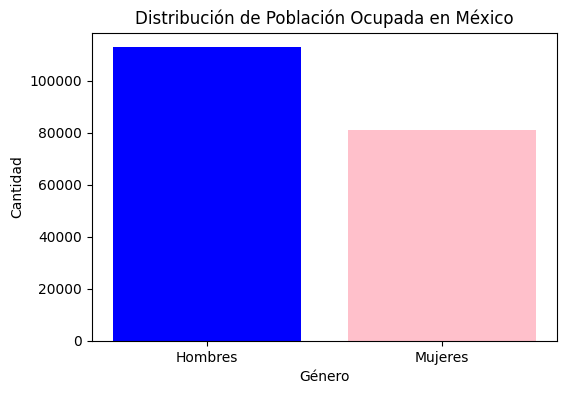

sex
Hombre    112800
Mujer      80892
Name: count, dtype: int64


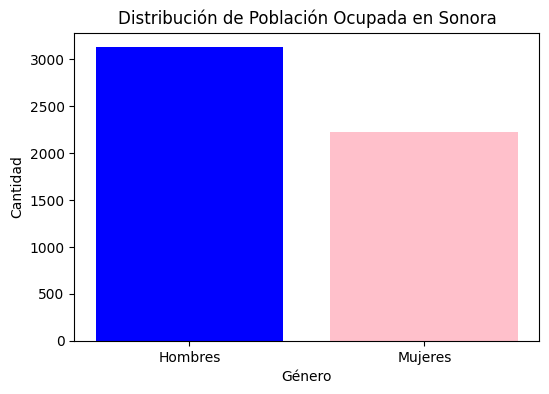

sex
Hombre    3127
Mujer     2221
Name: count, dtype: int64


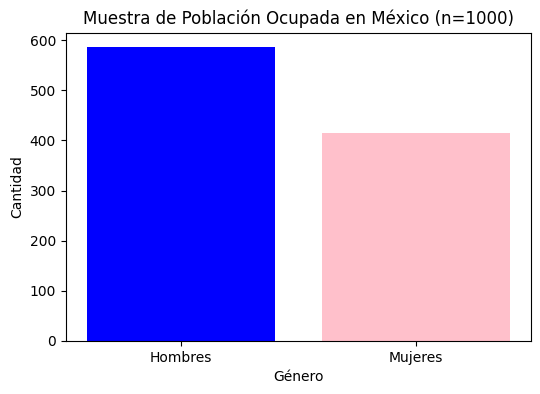

sex
Hombre    586
Mujer     414
Name: count, dtype: int64


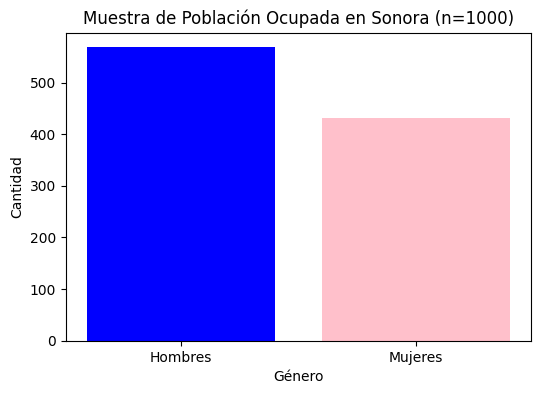

sex
Hombre    568
Mujer     432
Name: count, dtype: int64


In [ ]:
#Paso 5: Obtener la Población ocupada en México por género antes y despues del muestreo: Para el pais y para la entidad de Sonora. Sonora tiene la clave entidad=26
#Grafico de barras / opción 2 de visualización 
import pandas as pd
import matplotlib.pyplot as plt

# Cargar la base de datos Stata (.dta)
df = pd.read_stata('enoe_23t4.dta')

# Filtrar solo la población ocupada
df_ocupada = df[df['clase2'] == 'PoblaciÃ³n ocupada']

# Filtrar la población ocupada en todo México y en Sonora
mexico = df_ocupada.copy()
sonora = df_ocupada[df_ocupada['ent'] == 'Sonora']

# Función para mostrar la distribución por género
def mostrar_distribucion(data, titulo):
    conteo = data['sex'].value_counts()
    etiquetas = ['Hombres', 'Mujeres']
    plt.figure(figsize=(6,4))
    plt.bar(etiquetas, conteo, color=['blue', 'pink'])
    plt.xlabel('Género')
    plt.ylabel('Cantidad')
    plt.title(titulo)
    plt.show()
    print(conteo)

# Mostrar distribución antes de la muestra
distribucion_mexico = mostrar_distribucion(mexico, 'Distribución de Población Ocupada en México')
distribucion_sonora = mostrar_distribucion(sonora, 'Distribución de Población Ocupada en Sonora')

# Tomar muestra aleatoria representativa de n=1000
muestra_mexico = mexico.sample(n=1000, random_state=42)
muestra_sonora = sonora.sample(n=1000, random_state=42)

# Mostrar distribución después de la muestra
distribucion_muestra_mexico = mostrar_distribucion(muestra_mexico, 'Muestra de Población Ocupada en México (n=1000)')
distribucion_muestra_sonora = mostrar_distribucion(muestra_sonora, 'Muestra de Población Ocupada en Sonora (n=1000)')


In [1]:
# Respuesta a la preguntas del punto 6

import pandas as pd
import numpy as np
import scipy.stats as stats

# Cargar la base de datos Stata (.dta)
df = pd.read_stata('enoe_23t4.dta')

# Filtrar solo la población ocupada
df_ocupada = df[df['clase2'] == 'PoblaciÃ³n ocupada']

# Filtrar la población ocupada en todo México y en Sonora
mexico = df_ocupada.copy()
sonora = df_ocupada[df_ocupada['ent'] == 'Sonora']

# Función para mostrar la distribución por género en formato tabla
def mostrar_distribucion(data, titulo):
    conteo = data['sex'].value_counts().rename_axis('Género').reset_index(name='Cantidad')
    print(f"\n{titulo}")
    print(conteo.to_string(index=False))
    return conteo

# Mostrar distribución antes de la muestra
distribucion_mexico = mostrar_distribucion(mexico, 'Distribución de Población Ocupada en México')
distribucion_sonora = mostrar_distribucion(sonora, 'Distribución de Población Ocupada en Sonora')

# Tomar muestra aleatoria representativa de n=1000
muestra_mexico = mexico.sample(n=1000, random_state=42)
muestra_sonora = sonora.sample(n=1000, random_state=42)

# Mostrar distribución después de la muestra
distribucion_muestra_mexico = mostrar_distribucion(muestra_mexico, 'Muestra de Población Ocupada en México (n=1000)')
distribucion_muestra_sonora = mostrar_distribucion(muestra_sonora, 'Muestra de Población Ocupada en Sonora (n=1000)')

# 1. Comparar proporciones entre tabulados
def comparar_proporciones(distribucion_total, distribucion_muestra, titulo):
    proporciones_total = distribucion_total['Cantidad'] / distribucion_total['Cantidad'].sum()
    proporciones_muestra = distribucion_muestra['Cantidad'] / distribucion_muestra['Cantidad'].sum()
    comparacion = pd.DataFrame({'Género': distribucion_total['Género'], 'Proporción Total': proporciones_total, 'Proporción Muestra': proporciones_muestra})
    print(f"\nComparación de proporciones - {titulo}")
    print(comparacion.to_string(index=False))
    return comparacion

comparar_proporciones(distribucion_mexico, distribucion_muestra_mexico, 'México')
comparar_proporciones(distribucion_sonora, distribucion_muestra_sonora, 'Sonora')

# 2. Calcular intervalos de confianza del 95%
def calcular_intervalo_confianza(distribucion, n):
    conteo = distribucion['Cantidad'].values
    total = conteo.sum()
    proporciones = conteo / total
    errores = np.sqrt((proporciones * (1 - proporciones)) / n)  # Error estándar
    intervalo = [(p - 1.96 * e, p + 1.96 * e) for p, e in zip(proporciones, errores)]
    intervalos_df = pd.DataFrame({'Género': distribucion['Género'], 'Intervalo de Confianza': intervalo})
    print("\nIntervalos de Confianza (95%)")
    print(intervalos_df.to_string(index=False))
    return intervalos_df

calcular_intervalo_confianza(distribucion_muestra_mexico, 1000)
calcular_intervalo_confianza(distribucion_muestra_sonora, 1000)

# 3. Ventajas del muestreo aleatorio
def ventajas_muestreo():
    ventajas = [
        "Permite generalizar resultados a la población total.",
        "Reduce el sesgo en la selección de datos.",
        "Es eficiente en términos de costos y tiempo.",
        "Asegura una distribución representativa de la población ocupada."
    ]
    print("\nVentajas del Muestreo Aleatorio:")
    for v in ventajas:
        print(f"- {v}")

ventajas_muestreo()


Distribución de Población Ocupada en México
Género  Cantidad
Hombre    112800
 Mujer     80892

Distribución de Población Ocupada en Sonora
Género  Cantidad
Hombre      3127
 Mujer      2221

Muestra de Población Ocupada en México (n=1000)
Género  Cantidad
Hombre       586
 Mujer       414

Muestra de Población Ocupada en Sonora (n=1000)
Género  Cantidad
Hombre       568
 Mujer       432

Comparación de proporciones - México
Género  Proporción Total  Proporción Muestra
Hombre          0.582368               0.586
 Mujer          0.417632               0.414

Comparación de proporciones - Sonora
Género  Proporción Total  Proporción Muestra
Hombre          0.584705               0.568
 Mujer          0.415295               0.432

Intervalos de Confianza (95%)
Género                    Intervalo de Confianza
Hombre  (0.5554715292489125, 0.6165284707510874)
 Mujer (0.38347152924891253, 0.4445284707510874)

Intervalos de Confianza (95%)
Género                     Intervalo de Confianza
Hom